In [1]:
import asyncio
from pathlib import Path
import json
import logging
from rich import print
import rich.jupyter
import grpc

from daq_data.client import DaqDataClient, AioDaqDataClient
from daq_data.plot import PanoImagePreviewer, PulseHeightDistribution

%load_ext autoreload
%autoreload 2

## Configuration
`DaqDataClient` and `AioDaqDataClient` expect `daq_config` and `network_config`, which may be Python dictionaries or filesystem paths to JSON files.

Note that `network_config` is optional and may be omitted if your observatory does not use port forwarding.

```python
daq_config:
{
    'head_node_data_dir': '',
    'head_node_ip_addr': 'localhost',
    'daq_nodes': [
        {'ip_addr': '10.0.0.60', 'user_name': '', 'data_dir': 'simulated_data_dir', 'module_ids': '0-127'},
        {'ip_addr': '192.168.3.84', 'user_name': '', 'data_dir': 'simulated_data_dir', 'module_ids': '128-255'}
    ]
}

network_config:
{
    'modules': [
        {
            'ip_addr': '192.168.3.248',
            'port_forwarding': {
                'status': False,
                'gw_ip': '192.168.88.152',
                'reboot_port': [69, 60004, 60005, 60006],
                'cmd_port': [60000, 60001, 60002, 60003]
            }
        }
    ],
    'daq_nodes': [
        {'ip_addr': '192.168.3.84', 'port_forwarding': {'status': True, 'gw_ip': 'localhost', 'port': 22}},
        {'ip_addr': '192.168.3.83', 'port_forwarding': {'status': True, 'gw_ip': '10.0.0.60', 'port': 22}}
    ]
}

```

In [2]:
# Configure paths
cfg_dir = Path('daq_data/config')

daq_config_path = cfg_dir / 'daq_config_grpc_simulate.json'
network_config_path = cfg_dir / 'network_config_grpc_simulate.json'
hp_io_config_path = cfg_dir / 'hp_io_config_simulate.json'

# Load configuration files
with open(daq_config_path, 'r') as f:
    daq_config = json.load(f)

with open(network_config_path, 'r') as f:
    network_config = json.load(f)
    
with open(hp_io_config_path, 'r') as f:
    hp_io_config = json.load(f)

# Override the default HTML format to remove the bottom margin from <pre> tags.
rich.jupyter.JUPYTER_HTML_FORMAT = """
<pre style="white-space: pre; overflow-x: auto; margin: 0; padding: 0.1em; line-height: 1.2;">{code}</pre>
"""

In [ ]:
print("daq_config:", daq_config, "network_config:", network_config)

# DaqDataClient

This section demonstrates how to use the synchronous (blocking) `DaqDataClient` API.

## DaqDataClient Docstring

In [46]:
DaqDataClient?

Init signature:
DaqDataClient(
    daq_config: Union[str, pathlib.Path, Dict[str, Any]],
    network_config: Union[str, pathlib.Path, Dict[str, Any]],
    log_level: int = 20,
)
Docstring:     
A synchronous gRPC client for the PANOSETI DaqData service.

This client provides methods to interact with one or more DAQ nodes,
including pinging for health checks, initializing the data flow from the
observatory's data directory (`hp_io`), and streaming real-time image data.

It is designed to be used as a context manager, which automatically handles
the setup and teardown of gRPC connections:

with DaqDataClient(...) as client:
    client.ping(host)
Init docstring:
Initializes the DaqDataClient with DAQ and network configurations.

Args:
    daq_config: The DAQ system configuration. Can be a path to a
        `daq_config.json` file or a pre-loaded dictionary. This
        configuration must contain a 'daq_nodes' key with a list of DAQ
        node objects.
    network_config: The network con

## Minimal StreamImages Client

In [62]:
with DaqDataClient(daq_config, network_config) as client:
    # 1. Get valid hosts
    valid_hosts = client.get_valid_daq_hosts()
    if not valid_hosts:
        raise RuntimeError("No valid DAQ hosts found.")
    print(client.get_daq_host_status())

    # 2. Initialize servers in simulation mode
    all_init_success = client.init_sim(hosts=[])
    if not all_init_success:
        raise RuntimeError("Failed to initialize one or more servers.")
    print("All servers initialized for simulation.")

    # 3. Stream pulse-height and movie data from all modules
    image_stream = client.stream_images(
        hosts=[],
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=1.0,
        module_ids=()
    )

    # 4. Listen to the stream and process data
    print("Starting data stream. Press Ctrl+C to stop.")
    for image_data in image_stream:
        # In a real application, you would pass this data to a
        # visualization or analysis function.
        print(
            f"Image: Module {image_data['module_id']}, "
            f"Type: {image_data['type']}, "
            f"Timestamp: {image_data['header']['pandas_unix_timestamp']}"
        )

20:09:05 INFO     [__init__()] Using port forwarding: "daq_cfg_ip='192.168.3.84':50051" -->                        
                  "real_ip='localhost':50051"

{'10.0.0.60:50051': True, 'localhost:50051': True}

         INFO     [init_hp_io()] Initializing hp_io on 'localhost:50051'...

20:09:08 INFO     [init_hp_io()] host='localhost': init_hp_io_response.success=True

         INFO     [init_hp_io()] Initializing hp_io on '10.0.0.60:50051'...

## Visualization Clients

### Initialize Simulation Streaming 
For debugging and demonstration, we will start the servers in simulation streaming mode.

In [9]:
with DaqDataClient(daq_config_path, network_config_path) as ddc:

    # Check if any hosts are valid
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    if len(valid_daq_hosts) == 0:
        print(f"no valid daq hosts")

    # Initialize the server
    all_init_success = ddc.init_sim([])
    print(f"{all_init_success=}")

18:55:01 INFO     [__init__()] Using port forwarding: "daq_cfg_ip='192.168.3.84':50051" -->                        
                  "real_ip='localhost':50051"

         INFO     [init_hp_io()] Initializing hp_io on '10.0.0.60:50051'...

18:55:03 INFO     [init_hp_io()] host='10.0.0.60': init_hp_io_response.success=True

all_init_success=True

### Streaming from One DAQ node

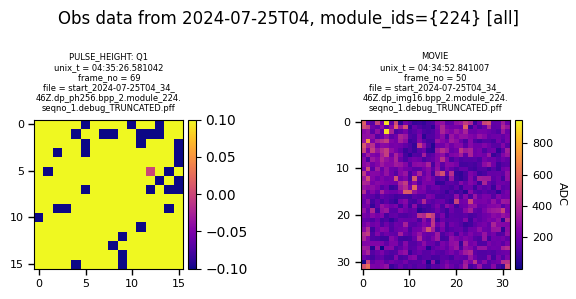

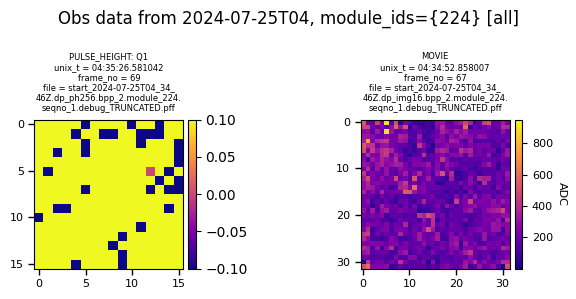

In [37]:
# Show PanoImagePreviewer: One DAQ node

with DaqDataClient(daq_config, network_config_path) as ddc:

    # Initialize simulation
    all_success = ddc.init_sim([])
    
    # Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data=True,
        stream_pulse_height_data=True,
        module_id_whitelist=[],
        jupyter_notebook=True
    )

    # Get first valid daq node
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    host = list(valid_daq_hosts)[0] 

    # Call the StreamImages RPC on one valid DAQ node
    pano_image_stream = ddc.stream_images(
        host,
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=1.0,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # Update visualization
    for pano_image in pano_image_stream:
        previewer.update(pano_image)

### Streaming from Multiple DAQ Nodes

Streaming from multiple DAQ nodes is no harder than streaming from a single DAQ node.

In [56]:
# Show PanoImagePreviewer: Multiple DAQ nodes

# 1. Connect to all DAQ nodes
with DaqDataClient(daq_config_path, network_config_path) as ddc:
    
    # 2. Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data=True,
        stream_pulse_height_data=True,
        module_id_whitelist=[],
        jupyter_notebook=True
    )
    
    # 3. Call the StreamImages RPC on all valid DAQ nodes
    pano_image_stream = ddc.stream_images(
        hosts=[],
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=0.25,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # 4. Update visualization for each pano_image
    for pano_image in pano_image_stream:
        previewer.update(pano_image)

20:02:42 INFO     [__init__()] Using port forwarding: "daq_cfg_ip='192.168.3.84':50051" -->                        
                  "real_ip='localhost':50051"

         INFO     [stream_images()] stream_images_request={'stream_movie_data': True, 'stream_pulse_height_data':  
                  True, 'update_interval_seconds': 0.25, 'module_ids': []}

         INFO     [stream_images()] Created StreamImages RPC to host='localhost'

         INFO     [stream_images()] Created StreamImages RPC to host='10.0.0.60'

Stream failed with RPC error: <_MultiThreadedRendezvous of RPC that terminated with:
        status = StatusCode.UNAVAILABLE
        details = "Server is being configured, please try again soon."
        debug_error_string = "UNKNOWN:Error received from peer  {grpc_message:"Server is being configured, please 
try again soon.", grpc_status:14}"
>

# AioDaqDataClient

This section demonstrates how to use the asynchronous (non-blocking) `AioDaqDataClient` API.

## AioDaqDataClient Docstring

In [45]:
AioDaqDataClient?

Init signature:
AioDaqDataClient(
    daq_config: Union[str, pathlib.Path, Dict[str, Any]],
    network_config: Union[str, pathlib.Path, Dict[str, Any]],
    log_level: int = 20,
)
Docstring:     
An asynchronous gRPC client for the PANOSETI DaqData service.

Built on `grpc.aio`, this client provides non-blocking methods to interact
with DAQ nodes, including pinging for health checks, initializing the data
flow (`hp_io`), and streaming real-time image data.

It is designed for use within an `asyncio` event loop and as an
asynchronous context manager, which automatically handles the setup and
teardown of gRPC connections:

async with AioDaqDataClient(...) as client:
    await client.ping(host)
Init docstring:
Initializes the AioDaqDataClient with DAQ and network configurations.

Args:
    daq_config: The DAQ system configuration. Can be a path to a
        `daq_config.json` file or a pre-loaded dictionary. This
        configuration must contain a 'daq_nodes' key with a list of DAQ
    

## Full `AioDaqDataClient`

In [38]:
async def main():
    """Main function to demonstrate the async client."""
    # Use the client as an asynchronous context manager
    async with AioDaqDataClient(daq_config, network_config, log_level=logging.INFO) as client:
        
        # 1. Get valid hosts
        valid_hosts = client.get_valid_daq_hosts()
        if not valid_hosts:
            print("No valid DAQ hosts found.")
            return
        print(f"Connected to: {valid_hosts}")

        # 2. Asynchronously initialize servers in simulation mode
        # The underlying RPC calls for each host will run concurrently.
        print("Initializing servers for simulation...")
        all_init_success = await client.init_sim(hosts=[])  # An empty hosts list tells the client to initialize all available hosts
        if not all_init_success:
            print("Failed to initialize one or more servers.")
            return
        print("All servers initialized successfully.")

        # 3. Stream data using 'async for'
        print("\nStarting data stream. Press Ctrl+C to stop.")
        
        image_stream = await client.stream_images(
            hosts=valid_hosts,
            stream_movie_data=True,
            stream_pulse_height_data=True,
            update_interval_seconds=1.0,
        )
        
        # 4. Iterate over the async generator
        async for image_data in image_stream:
            print(
                f"Image: Module {image_data['module_id']}, "
                f"Type: {image_data['type']}, "
                f"Timestamp: {image_data['header']['pandas_unix_timestamp']}"
            )
            
# Jupyter notebooks have their own event loop, so we can schedule our task onto it.
try:
    loop = asyncio.get_event_loop()
    main_task = loop.create_task(main())
    await main_task
except KeyboardInterrupt:
    print("\nExiting.")

19:44:14 INFO     [__init__()] Using port forwarding: "daq_cfg_ip='192.168.3.84':50051" -->                        
                  "real_ip='localhost':50051"

Connected to: {'localhost', '10.0.0.60'}

Initializing servers for simulation...

         INFO     [_init_single_host()] Initializing hp_io on localhost...

         INFO     [_init_single_host()] Initializing hp_io on 10.0.0.60...

19:44:16 INFO     [_init_single_host()] host='localhost': init_hp_io_response.success=True

         INFO     [_init_single_host()] host='10.0.0.60': init_hp_io_response.success=True

All servers initialized successfully.

Starting data stream. Press Ctrl+C to stop.

         INFO     [stream_images()] Created 2 StreamImages RPCs to hosts: {'localhost', '10.0.0.60'}

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:05.163444705

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.745007488

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:04.365469316

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.743007488

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:08.978875626

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.764007488

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:08.059049100

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.760007488

Image: Module 888, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:12.071855114

Image: Module 888, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.784007488

Stream cancelled.

## Asynchronous Visualization Clients

### Initialize Simulation Streaming 
`AioDaqDataClient` can send out initialization requests to all DAQ nodes in parallel.

So if it takes `T` seconds to initialize one DaqData server, the `AioDaqDataClient` can initialize all servers in `T` seconds.
While it is possible to use thread pools to achieve a similar result with the synchronous `DaqDataClient`, the asyncio approach is more efficient.

In [28]:
async def main():
    # Use the client as an asynchronous context manager
    async with AioDaqDataClient(daq_config, network_config, log_level=logging.INFO) as client:
        # Asynchronously initialize servers in simulation mode
        # The underlying RPC calls for each host will run concurrently.
        print("Initializing servers for simulation...")
        all_init_success = await client.init_sim(hosts=[])  # An empty hosts list tells the client to initialize all available hosts
        if not all_init_success:
            print("Failed to initialize one or more servers.")
            return
        print("All servers initialized successfully.")


# Jupyter notebooks have their own event loop, so we can schedule our task onto it.
try:
    loop = asyncio.get_event_loop()
    main_task = loop.create_task(main())
    await main_task
except KeyboardInterrupt:
    print("\nExiting.")

20:22:43 INFO     [__init__()] Using port forwarding: "daq_cfg_ip='192.168.3.84':50051" -->                        
                  "real_ip='localhost':50051"

Initializing servers for simulation...

         INFO     [_init_single_host()] Initializing hp_io on localhost...

         INFO     [_init_single_host()] Initializing hp_io on 10.0.0.60...

20:22:45 INFO     [_init_single_host()] host='localhost': init_hp_io_response.success=True

         INFO     [_init_single_host()] host='10.0.0.60': init_hp_io_response.success=True

All servers initialized successfully.

### (Asynchronous) Streaming from Multiple DAQ Nodes 

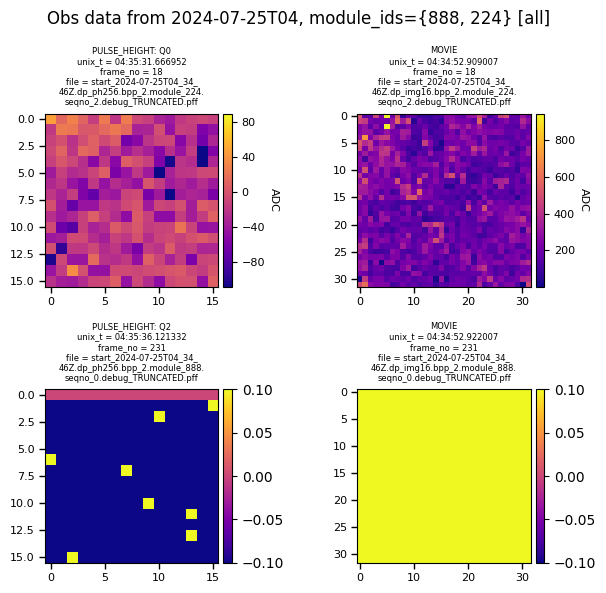


Stream cancelled.


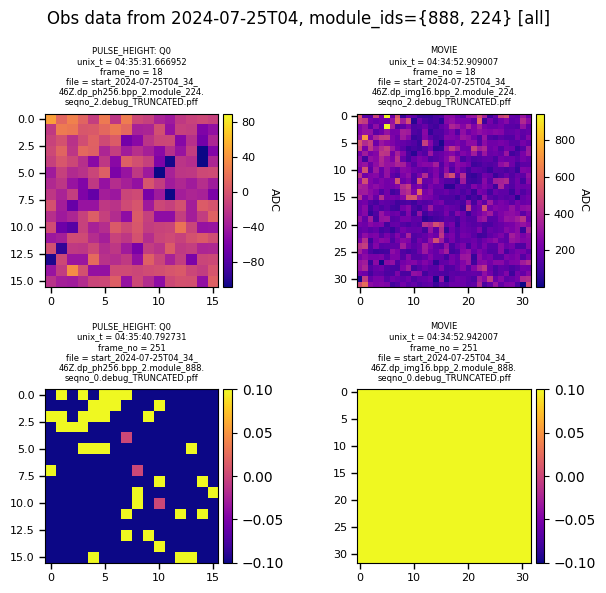

In [27]:
async def main():
    """Main function to demonstrate the async client."""
    # Use the client as an asynchronous context manager
    async with AioDaqDataClient(daq_config, network_config, log_level=logging.INFO) as client:
        
        # 1. Instantiate visualization class
        previewer = PanoImagePreviewer(
            stream_movie_data=True,
            stream_pulse_height_data=True,
            module_id_whitelist=[],
            jupyter_notebook=True
        )

        # 2. Stream data using 'async for'
        print("\nStarting data stream. Press Ctrl+C to stop.")
        pano_image_stream = await client.stream_images(
            hosts=[],
            stream_movie_data=True,
            stream_pulse_height_data=True,
            update_interval_seconds=1.0,
        )
        
        # 3. Iterate over the async generator and update the visualization for each pano_image
        async for pano_image in pano_image_stream:
            previewer.update(pano_image)

# Jupyter notebooks have their own event loop, so we can schedule our task onto it.
try:
    loop = asyncio.get_event_loop()
    main_task = loop.create_task(main())
    await main_task
except KeyboardInterrupt:
    print("\nExiting.")
    await main_task.cancel()